###  Malaria Detection        

In [1]:
import os
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread

%matplotlib inline

In [2]:
pwd

'C:\\Users\\Besitzer\\Desktop\\Machine Learning\\practise\\CNN'

In [3]:
my_data_dir = 'C:\\Users\\Besitzer\\Desktop\\Machine Learning\\practise\\CNN\\cell_images'

In [4]:
os.listdir(my_data_dir)

['test', 'train']

In [5]:
test_path = my_data_dir+'\\test\\'
train_path= my_data_dir+'\\train\\'

In [6]:
os.listdir(test_path)

['parasitized', 'uninfected']

In [7]:
os.listdir(train_path)

['parasitized', 'uninfected']

In [8]:
os.listdir(train_path+'\\parasitized')[0]

'C100P61ThinF_IMG_20150918_144104_cell_162.png'

In [9]:
para_cell = train_path+'\\parasitized\\'+'C100P61ThinF_IMG_20150918_144104_cell_162.png'

In [10]:
para_img = imread(para_cell)

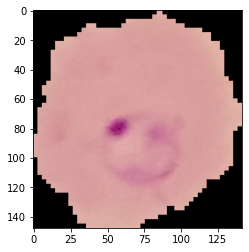

In [11]:
plt.imshow(para_img)

In [12]:
para_img.shape

(148, 142, 3)

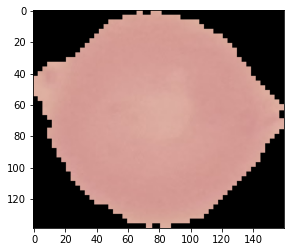

In [13]:
uninfected_cell_path = train_path+'\\uninfected\\'+os.listdir(train_path+'\\uninfected')[0]
uninfected_cell = imread(uninfected_cell_path)
plt.imshow(uninfected_cell)

In [14]:
len(os.listdir(train_path+'\\parasitized'))

12480

In [15]:
len(os.listdir(train_path+'\\uninfected'))

12479

In [16]:
uninfected_cell.shape

(139, 160, 3)

In [17]:
para_img.shape

(148, 142, 3)

In [18]:
#to check the average dimensions of the image

dim1 = []
dim2 = []

for image_filename in os.listdir(train_path+'\\uninfected'):
    
    img = imread(train_path+'\\uninfected\\'+image_filename)
    d1, d2, colors = img.shape
    dim1.append(d1)
    dim2.append(d2)

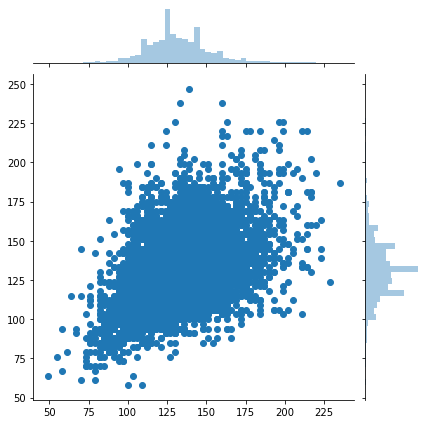

In [19]:
sns.jointplot(dim1,dim2)

In [20]:
np.mean(dim1)

131.64820899110507

In [21]:
np.mean(dim2)

131.4041990544114

In [22]:
image_shape = (130,130,3)

### Preparing the Data 

In [23]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [37]:
image_gen = ImageDataGenerator(rotation_range=20,
                               width_shift_range=0.10,
                               height_shift_range=0.10,
                               shear_range=0.10,
                               zoom_range=0.10,
                               horizontal_flip=True,
                               fill_mode='nearest')

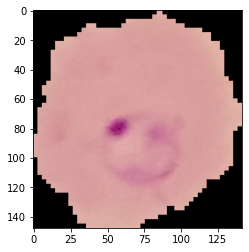

In [38]:
plt.imshow(para_img)

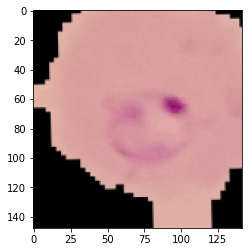

In [39]:
plt.imshow(image_gen.random_transform(para_img))

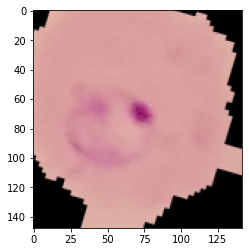

In [40]:
plt.imshow(image_gen.random_transform(para_img))

In [41]:
train_path

'C:\\Users\\Besitzer\\Desktop\\Machine Learning\\practise\\CNN\\cell_images\\train\\'

In [42]:
image_gen.flow_from_directory(train_path)

Found 24958 images belonging to 2 classes.


In [43]:
image_gen.flow_from_directory(test_path)

Found 2600 images belonging to 2 classes.


### Creating the Model

In [31]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image


from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPool2D, Activation

In [64]:
IMAGE_SIZE = [224,224]
vgg = VGG16(include_top=False,weights='imagenet',input_shape=IMAGE_SIZE+[3])

for layer in vgg.layers:
  layer.trainable = False

x = Flatten()(vgg.output)
x = Dense(256,activation='relu')(x)
output = Dense(1,activation='sigmoid')(x)

vgg_model = Model(inputs=vgg.input,outputs=output)

In [65]:
vgg_model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [66]:
vgg_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [67]:
from tensorflow.keras.callbacks import EarlyStopping

In [68]:
early_stop = EarlyStopping(monitor='val_loss',patience=2,restore_best_weights=True)

In [69]:
batch_size = 16

In [70]:
train_image_gen = image_gen.flow_from_directory(train_path,target_size=IMAGE_SIZE[:2],color_mode='rgb',batch_size=batch_size,
                                                class_mode='binary')

Found 24958 images belonging to 2 classes.


In [71]:
test_image_gen = image_gen.flow_from_directory(test_path,target_size=IMAGE_SIZE[:2],color_mode='rgb',batch_size=batch_size,
                                               class_mode='binary')

Found 2600 images belonging to 2 classes.


In [72]:
train_image_gen.class_indices

{'parasitized': 0, 'uninfected': 1}

In [73]:
import warnings
warnings.filterwarnings('ignore')

In [75]:
results = vgg_model.fit_generator(train_image_gen,epochs=1,validation_data=test_image_gen,callbacks=[early_stop])

1560/1560 [==============================] - 7856s 5s/step - loss: 0.2784 - accuracy: 0.9283 - val_loss: 0.1614 - val_accuracy: 0.9431


In [77]:
from tensorflow.keras.models import load_model
vgg_model.save('malaria_detector.h5')

In [79]:
losses = pd.DataFrame(vgg_model.history.history)

In [80]:
losses.head(2)

,loss,accuracy,val_loss,val_accuracy
0,0.278424,0.92828,0.161405,0.943077


In [84]:
vgg_model.evaluate_generator(test_image_gen)

Instructions for updating:
Please use Model.evaluate, which supports generators.


[0.15478910505771637, 0.9473077058792114]

In [85]:
from tensorflow.keras.preprocessing import image

In [86]:
pred_prob = vgg_model.predict_generator(test_image_gen)

Instructions for updating:
Please use Model.predict, which supports generators.


In [94]:
pred_prob

array([[9.57931399e-01],
       [1.73843944e-08],
       [1.15706086e-01],
       ...,
       [9.47142363e-01],
       [9.89874303e-01],
       [9.58578229e-01]], dtype=float32)

In [95]:
test_image_gen.classes

array([0, 0, 0, ..., 1, 1, 1])

In [96]:
predictions = pred_prob > 0.5

In [97]:
predictions

array([[ True],
       [False],
       [False],
       ...,
       [ True],
       [ True],
       [ True]])

In [98]:
from sklearn.metrics import classification_report, confusion_matrix

In [99]:
print(classification_report(test_image_gen.classes,predictions))

              precision    recall  f1-score   support

           0       0.51      0.50      0.50      1300
           1       0.51      0.51      0.51      1300

    accuracy                           0.51      2600
   macro avg       0.51      0.51      0.51      2600
weighted avg       0.51      0.51      0.51      2600



In [111]:
print(confusion_matrix(test_image_gen.classes,predictions))

[[651 649]
 [631 669]]


In [102]:
#the performance is almost same as our own model in another notebook, 
#but we have trained the VGG net for only one epoch and it can be trained for more epochs for better results.

In [103]:
vgg_model.save('VGGModelformalaria.h5')

In [104]:
from tensorflow.keras.models import load_model 
loaded_model = load_model('VGGModelformalaria.h5')

In [105]:
loaded_model.layers

In [110]:
loaded_model.get_weights()

[array([[[[ 4.29470569e-01,  1.17273867e-01,  3.40129584e-02, ...,
           -1.32241577e-01, -5.33475243e-02,  7.57738389e-03],
          [ 5.50379455e-01,  2.08774377e-02,  9.88311544e-02, ...,
           -8.48205537e-02, -5.11389151e-02,  3.74943428e-02],
          [ 4.80015397e-01, -1.72696680e-01,  3.75577137e-02, ...,
           -1.27135560e-01, -5.02991639e-02,  3.48965675e-02]],
 
         [[ 3.73466998e-01,  1.62062630e-01,  1.70863140e-03, ...,
           -1.48207128e-01, -2.35300660e-01, -6.30356818e-02],
          [ 4.40074533e-01,  4.73412387e-02,  5.13819456e-02, ...,
           -9.88498852e-02, -2.96195745e-01, -7.04357103e-02],
          [ 4.08547401e-01, -1.70375049e-01, -4.96297423e-03, ...,
           -1.22360572e-01, -2.76450396e-01, -3.90796512e-02]],
 
         [[-6.13601133e-02,  1.35693997e-01, -1.15694344e-01, ...,
           -1.40158370e-01, -3.77666801e-01, -3.00509870e-01],
          [-8.13870355e-02,  4.18543853e-02, -1.01763301e-01, ...,
           -9.431